#  Test a few statistical analyses on the borders of chromatin interaction domains identified in a HiC map from E. coli

Please use the next cell to adjust the two following variables according to your installation: 
- path to GRATIOSA package
- path to database

In [3]:
import sys
## PATH TO PACKAGE:
## ----------------
## IF ALREADY IN YOUR PYTHON PATH (e.g. installation through Pip): nothing to do
## IF NOT IN YOUR PYTHON PATH (e.g. download from GitHub): 
## uncomment and adjust the following relevant line to the location of the GRATIOSA directory
## - For Linux/MacOS:             typical style ;-)
#sys.path.append('/home/usr/Python_venv/lib/python3.8/site-packages/') 
# sys.path.insert(0,"/home/s/Téléchargements/GRATIOSA-master/")
#sys.path.append("/home/s/Downloads/GRATIOSA-master/")
## (- For Windows:                  typical style ;-)
#sys.path.append('C:\\Downloads\\GRATIOSA-master')

import os
## PATH TO DATABASE:
## -----------------
## FOR REGULAR USE OF THE PACKAGE:
#  Please set your system environment variable \$GRATIOSA_DB_PATH in order to have 
#  \$GRATIOSA_DB_PATH + data/organisms (e.g. export GRATIOSA_DB_PATH=/home/usr/documents/GRATIOSA/).
## FOR THIS TUTORIAL ONLY:
#  you can skip the system environment variable and just use the following line
#  We assume that the "data" directory containing the database is in the parent directory (otherwise adjust line)
os.environ["GRATIOSA_DB_PATH"]=os.getcwd()+"/../"
print("Using the database stored in: %s. Please check that this is correct."%(os.environ["GRATIOSA_DB_PATH"]))

Using the database stored in: /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../. Please check that this is correct.


In [4]:
# Loading the modules for data loading
from GRATIOSA import Genome, HiC, Transcriptome, GO

# Loading the statistical analysis and graphic modules
from GRATIOSA import stat_analysis, plot_stat_analysis
import numpy as np

## 1 - Data loading
#### Genomic annotation loading

In [5]:
g = Genome.Genome("ecoli")
g.load_seq()
g.load_annotation()

Detected a genome with 1 chromosome
Chromosome U00096.3 of length 4641652
Sequence of organism ecoli loaded
Trying to load annotation from: /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../data/ecoli/annotation/sequence.gff3
Annotation of ecoli loaded
Number of genes: 4314


#### Load the borders of chromatin interactions domains obtained from a HiC dataset

The employed dataset is https://www.ncbi.nlm.nih.gov/sra/SRX7095271. The borders between adjacent domains were computed using Chromosight (https://github.com/koszullab/chromosight), using standard parameters and 2-kb bins. The output file SRR10394904.tsv contains the coordinates of these borders. 
We placed that file into the "ecoli/sites" directory and updated the "sites.info" file to indicate the relevant information. 

In [6]:
g.load_sites()

Loading condition ['all']
Successful loading of sites


In [7]:
# The borders are contained in a dictionary with key "borders_SRR10394904"
g.sites.keys()

dict_keys(['borders_SRR10394904'])

In [8]:
# We verify that each site has a width of 2000 bp
g.sites['borders_SRR10394904'][:4]

array([[1140000, 1142000],
       [1968000, 1970000],
       [  34000,   36000],
       [ 110000,  112000]])

## 2 - Attribute genes to sites

In [9]:
# use a function to compute genes that overlap each border
# each border is 2000 bp long
g.load_genes_per_pos(2000)

Operation genes_per_pos completed for genome ecoli


In [10]:
# Then associate the list of genes around the central position of each border. 
border_genes = []
for site in g.sites["borders_SRR10394904"]:
    genes = g.genes_per_pos[(site[0]+site[1])/2]
    if genes != [None] : 
        border_genes.extend(genes)
border_genes =  list(dict.fromkeys(border_genes))
no_border_genes = [i for i in list(g.genes.keys()) if i not in border_genes]
border_dict = {"border": border_genes, "else": no_border_genes}

In [11]:
len(border_genes)

246

## 3 - Gene orientation 

Test if we observe an enrichment in particular orientations between neighboring genes at the borders. 

In [12]:
g.load_gene_orientation()

Operation load_neighbor_all completed for genome ecoli
Operation load_gene_orientation completed for genome ecoli


In [13]:
# has created dictionaries with lists of genes by orientation
g.orientation.keys()

dict_keys(['tandem', 'divergent', 'convergent', 'isolated'])

tandem: 2703 valid elements
convergent: 797 valid elements
divergent: 800 valid elements
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/enrichment_test/test_border_orientation.csv
     Category  Selected_gene_nb  Expected_selected_nb  Adj p-value (FDR)
1  convergent                58             45.447844           0.069001
0      tandem               147            154.134910           0.849903
2   divergent                41             45.618915           0.849903
     Category  Selected_gene_nb  Total_gene_nb  Proportion     Prop_conf_int  \
1  convergent                58            797    0.072773  [0.0583, 0.0872]   
0      tandem               147           2703    0.054384  [0.0492, 0.0596]   
2   divergent                41            800    0.051250  [0.0369, 0.0656]   

    p-value  Adj p-value (FDR)  Global_proportion  Expected_selected_nb  
1  0.023000           0.069001           0.057024             45.447844  
0  0.849903           0

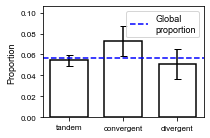

In [14]:
# Compute and plot the enrichment graph for the different orientations of genes at/around borders
plot_stat_analysis.plot_enrichment_test(
    # insert the two dictionaries of genes: orientation and border
    g.orientation, border_dict,
    targ_features=["border"],
    targ_cats=["tandem","convergent","divergent"],
    figsize = (3,2),
    output_file="test_border_orientation")

The borders are (maybe surprisingly) enriched in convergent genes, at the limit of statistical detection (P-value of 0.023 adjusted to 0.069). This was not observed before, especially since borders are thought to contain many highly expressed operons that are usually rarely convergent. 

## 4 - Expression level 

Test on this dataset if we detect the presence of highly expressed operons at domain borders, as previously observed with other data. 

In [15]:
# Import of an arbitrary dataset of RNA-Seq data in standard growth conditions (processed data imported from publication)
# We used Supp Table S3 from Zhang et al., Mol Cell 2019, https://doi.org/10.1016%2Fj.molcel.2018.02.035
# The file was located in /ecoli/expression and the expression.info file was formatted accordingly
# Gene expressions are given there as the fraction of RPKM for each gene compared to the total RPKMs
tr=Transcriptome.Transcriptome(g)
tr.load_expression()

Loading condition: base
3367 expressions were successfully loaded
240 locus are not in annotation
745 expressions are null and led to math domain error


In [41]:
?plot_stat_analysis.plot_student_test

In [16]:
# Create dictionary with log-expression of each gene, in borders and outside borders
# Add an arbitrary constant to gene log2RPKM values to obtain positive expression values (does not affect the results)
expr_dict={}
for b in border_dict.keys():
    expr_dict[b]=[g.genes[ge].expression["base"]+16 for ge in tr.genes_valid_expr["base"].keys() if ge in border_dict[b]]

Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/student_test/student_test2024-06-11 16:33:02.773310


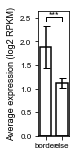

In [17]:
plot_stat_analysis.plot_student_test(expr_dict,ylabel="Average expression (log2 RPKM)")

As expected, we observe a stronger average expression for genes located at domain borders, with high statistical confidence (see exported file, P=2.5e-4). The average expression is around two-fold higher for genes located at/around borders. 

### Check that, usually (in the genome), there are less highly expressed genes among convergent genes than others, for comparison. We divide genes into strongly/weakly expressed (compared to the median) and check the proportion of weakly expressed genes by orientation

tandem: 2071 valid elements
convergent: 641 valid elements
divergent: 645 valid elements
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/enrichment_test/test_orientation_high_expr.csv
     Category  Selected_gene_nb  Expected_selected_nb  Adj p-value (FDR)
1  convergent               372            320.595189           0.000011
0      tandem               994           1035.807544           0.998640
2   divergent               312            322.595783           0.998640
     Category  Selected_gene_nb  Total_gene_nb  Proportion     Prop_conf_int  \
1  convergent               372            641    0.580343  [0.5452, 0.6154]   
0      tandem               994           2071    0.479961  [0.4667, 0.4932]   
2   divergent               312            645    0.483721  [0.4488, 0.5186]   

    p-value  Adj p-value (FDR)  Global_proportion  Expected_selected_nb  
1  0.000004           0.000011           0.500149            320.595189  
0  0.998640         

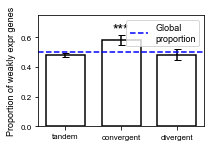

In [19]:
# Create a dictionary with genes separated into above or below median expression
med_expr=np.median([g.genes[ge].expression["base"] for ge in tr.genes_valid_expr["base"]])
high_expr_genes = [ge for ge in list(tr.genes_valid_expr["base"].keys()) if g.genes[ge].expression["base"]>med_expr]
low_expr_genes = [i for i in list(tr.genes_valid_expr["base"].keys()) if i not in high_expr_genes]
expr_dict = {"high": high_expr_genes, "low": low_expr_genes}
# Compute enrichment graph of weakly expressed genes in different orientations
# CAUTION: in the present version, the enrichment test only looks for ENRICHED categories. 
plot_stat_analysis.plot_enrichment_test(
    # insert the two dictionaries of genes: orientation and border
    g.orientation, expr_dict,
    targ_features=["low"],
    targ_cats=["tandem","convergent","divergent"],
    ylabel="Proportion of weakly expr genes",
    figsize = (3,2),
    output_file="test_orientation_high_expr")

This shows that convergent genes are enriched in WEAKLY expressed genes. The presence of convergent and highly expressed genes at the borders is an unusual feature. 

## 5 - Functional enrichment analysis (GO annotation)

See if we observe an enrichment of particular functional categories at domain borders

#### GO annotation loading

In [22]:
g.load_GO()
dict_GO = g.GO['GO']

Loading GO...
	4128 genes were successfully associated with some GO terms
	186 genes were not associated with any GO term


#### Functional enrichment analysis

In [23]:
# Use the built-in function to compute the enrichment of ALL GO terms in genes located at/around borders
# Beware that, because we test 600 GO terms simultaneously, this operation results in huge corrections of p-values and a loss of statistical power if the focus is on a particular function
GO.GO_enrichment_test(dict_GOterms=g.GO["GO"],dict_features=border_dict,targ_features="border")

48 GO terms are not in the GO annotation
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/enrichment_test/enrich_test2024-06-11 16:33:02.773059_GOc.csv
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/enrichment_test/enrich_test2024-06-11 16:33:02.773059_GOp.csv
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/enrichment_test/enrich_test2024-06-11 16:33:02.773059_GOf.csv
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/revision/tutorials/../resdir/enrichment_test/enrich_test2024-06-11 16:33:02.773059_significant.csv


Focusing on GO "biological process" components (file ending in "_GOp"), we find 10 terms with enrichment associated to a p-value < 0.01. Because of the huge number of simultaneous tests, the adjusted p-value is not significant, so additional (more focused) tests would be required to validate the observed enrichments. The enriched functions are associated to biosynthetic processes, translation, flagellum assembly, and transport - in agreement with the expected presence of strongly expressed operons. 